In [1]:
import numpy as np 
import plotly.express as px 
import pandas as pd 
import cv2 
import os 
from glob import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle 

## Appending All files

In [2]:
df_list = []
for file_name in glob("../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list


In [3]:
df = df.dropna()


In [4]:
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: os.path.join('../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"), axis=1)


In [5]:
age_mapper = {'35': '(38, 48)','34': '(38, 48)','36': '(38, 48)','55':'(60, 100)','57':'(60, 100)','58':'(60, 100)','23':'(8, 23)','3':'(0, 2)','2':'(0, 2)'}
for elem in df[df['age'].str.startswith("(")]['age'].value_counts().index:
    age_mapper[elem] = elem
df['age'] = df['age'].map(age_mapper)

In [6]:
df = df[df['age'] != 'None']

In [7]:
new_df = df[df['gender'] != 'u'][['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]

In [8]:
del df

In [9]:
new_df['gender'] = new_df['gender'].apply(lambda x : 1 if x == 'm' else 0).astype(np.float32)

In [10]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
new_df['age'] = le.fit_transform(new_df['age'])

In [11]:
with open('age_encoder.pkl','wb') as pkl_file:
    pickle.dump(le, pkl_file)

In [12]:
X = new_df[['image_path']].values 
y = new_df[['gender']].values 


In [13]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 

In [14]:
def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 

In [15]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


2022-04-14 06:49:22.532669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 06:49:22.539737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 06:49:22.541210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 06:49:22.545489: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

## Simple CNN Gender

In [17]:
inputs = tf.keras.Input(shape = (128,128,3))
x = Conv2D(128, 3, activation='relu')(inputs)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)



In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [19]:
history = model.fit(ds_train, validation_data=ds_test,epochs=50)

Epoch 1/50


2022-04-14 06:49:26.295050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-14 06:49:36.545280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 702 of 1000
2022-04-14 06:49:40.591848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-04-14 06:49:41.724997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


    438/Unknown - 191s 388ms/step - loss: 0.8346 - accuracy: 0.5254

2022-04-14 06:52:46.920358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 807 of 1000
2022-04-14 06:52:49.306571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


438/438 [==============================] - 236s 489ms/step - loss: 0.8346 - accuracy: 0.5254 - val_loss: 0.7915 - val_accuracy: 0.5427
Epoch 2/50
438/438 [==============================] - 9s 21ms/step - loss: 0.7291 - accuracy: 0.5398 - val_loss: 2.3382 - val_accuracy: 0.5430
Epoch 3/50
438/438 [==============================] - 9s 21ms/step - loss: 0.7042 - accuracy: 0.5496 - val_loss: 0.7618 - val_accuracy: 0.5119
Epoch 4/50
438/438 [==============================] - 9s 22ms/step - loss: 0.7090 - accuracy: 0.5401 - val_loss: 0.7726 - val_accuracy: 0.5430
Epoch 5/50
438/438 [==============================] - 9s 21ms/step - loss: 0.6922 - accuracy: 0.5629 - val_loss: 0.9838 - val_accuracy: 0.5430
Epoch 6/50
438/438 [==============================] - 9s 21ms/step - loss: 0.6864 - accuracy: 0.5811 - val_loss: 2.4434 - val_accuracy: 0.5430
Epoch 7/50
438/438 [==============================] - 9s 22ms/step - loss: 0.6919 - accuracy: 0.5612 - val_loss: 1.1449 - val_accuracy: 0.4570
Epoch 8

In [20]:
model.save('my_model.h5')

## Agumentation

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [22]:
for image, _ in  ds_train.take(1):
    my_image = image 
image = my_image[2]
image = tf.cast(tf.expand_dims(image, 0), tf.float32)


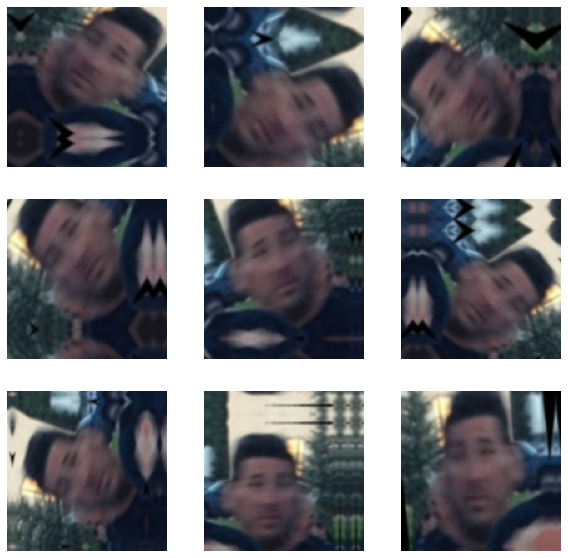

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [24]:
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [25]:
history = model.fit(ds_train, validation_data=ds_test,epochs=20)

Epoch 1/20
438/438 [==============================] - 12s 24ms/step - loss: 0.8332 - accuracy: 0.5193 - val_loss: 0.7290 - val_accuracy: 0.5430
Epoch 2/20
438/438 [==============================] - 10s 24ms/step - loss: 0.7427 - accuracy: 0.5237 - val_loss: 0.6845 - val_accuracy: 0.5467
Epoch 3/20
438/438 [==============================] - 11s 26ms/step - loss: 0.7148 - accuracy: 0.5322 - val_loss: 0.7717 - val_accuracy: 0.5293
Epoch 4/20
438/438 [==============================] - 11s 24ms/step - loss: 0.7004 - accuracy: 0.5478 - val_loss: 0.7116 - val_accuracy: 0.4847
Epoch 5/20
438/438 [==============================] - 11s 25ms/step - loss: 0.7048 - accuracy: 0.5411 - val_loss: 0.8888 - val_accuracy: 0.4570
Epoch 6/20
438/438 [==============================] - 10s 24ms/step - loss: 0.6984 - accuracy: 0.5514 - val_loss: 0.7088 - val_accuracy: 0.5133
Epoch 7/20
438/438 [==============================] - 11s 26ms/step - loss: 0.6902 - accuracy: 0.5626 - val_loss: 0.7207 - val_accuracy:

In [26]:
model.save('simple_model_agumentation.h5')

## Age Model

In [27]:
X = new_df[['image_path']].values
y = new_df[['age']].values

def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 
        
def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [28]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [29]:
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


In [30]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)

In [31]:
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [32]:
history = model.fit(ds_train, validation_data=ds_test,epochs=100)

Epoch 1/100
465/465 [==============================] - 85s 180ms/step - loss: 2.5609 - accuracy: 0.2037 - val_loss: 2.2856 - val_accuracy: 0.2931
Epoch 2/100
465/465 [==============================] - 11s 24ms/step - loss: 2.2757 - accuracy: 0.2444 - val_loss: 2.2780 - val_accuracy: 0.2889
Epoch 3/100
465/465 [==============================] - 11s 24ms/step - loss: 2.1822 - accuracy: 0.2652 - val_loss: 2.0365 - val_accuracy: 0.3037
Epoch 4/100
465/465 [==============================] - 12s 25ms/step - loss: 2.1302 - accuracy: 0.2730 - val_loss: 2.8340 - val_accuracy: 0.2927
Epoch 5/100
465/465 [==============================] - 11s 24ms/step - loss: 2.0855 - accuracy: 0.2873 - val_loss: 2.0491 - val_accuracy: 0.2912
Epoch 6/100
465/465 [==============================] - 11s 24ms/step - loss: 2.0432 - accuracy: 0.2977 - val_loss: 2.2338 - val_accuracy: 0.2245
Epoch 7/100
465/465 [==============================] - 11s 24ms/step - loss: 1.9952 - accuracy: 0.3148 - val_loss: 1.9432 - val_a